In [15]:
pip install tiktoken protobuf

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Set, Optional
from collections import defaultdict, Counter
from scipy.optimize import linprog
from sklearn.model_selection import KFold
from typing import Dict, List, Tuple, Set, Optional
import gc

# Import transformers
from transformers import AutoTokenizer

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Fix tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [17]:
# Add the project root to path to allow imports from src
notebook_path = Path(os.getcwd())
project_root = notebook_path.parent
sys.path.append(str(project_root))

# Define time periods
TIME_PERIODS = {
    '1850s': (1850, 1859),
    '1860s': (1860, 1869),
    '1870s': (1870, 1879),
    '1880s': (1880, 1889),
    '1890s': (1890, 1899),
    '1900s': (1900, 1909),
    '1910s': (1910, 1919),
    '1920s': (1920, 1929),
    '1930s': (1930, 1939),
    '1940s': (1940, 1949),
    '1950s': (1950, 1959),
    '1960s': (1960, 1969),
    '1970s': (1970, 1979),
    '1980s': (1980, 1989),
    '1990s': (1990, 1999),
    '2000s': (2000, 2009),
    '2010s': (2010, 2019),
    '2020s': (2020, 2029)
}

# Define directories
PROCESSED_DATA_DIR = Path('data/processed')
RESULTS_DIR = Path('results/comparative_analysis')

# Create necessary directories
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# List of models to analyze
'''MODEL_LIST = [
    # Baseline model with known distribution (primarily English web text)
    "gpt2",
    
    # Models with different data sources but undocumented temporal distributions
    "EleutherAI/gpt-neo-125M",          # The Pile dataset (mix of sources)
    "facebook/opt-125m",                # Unknown temporal mix from web crawls
    "bigscience/bloom-560m",            # Multilingual dataset, unknown temporal spread
    
    # Specialized models with different focuses
    "roberta-base",                     # Web data with different curation approach than GPT-2
    "microsoft/deberta-v3-small",       # More recent training data
    "distilbert-base-uncased",          # Different knowledge distillation approach
    
    # Academic models with likely different temporal distributions
    "allenai/longformer-base-4096",     # Scientific papers emphasis
    "google/electra-small-generator"    # Different pretraining objective
]
'''
MODEL_LIST = [
    # Core BERT family models - each with different training data
    "bert-base-uncased",           # Wikipedia + BookCorpus (2018)
    "distilbert-base-uncased",     # Knowledge distillation from BERT (2019)
    "roberta-base",                # Trained on much more web data than BERT (2019)
    
    # Models with significantly different training corpora
    "xlnet-base-cased",            # Different pretraining objective and corpus (2019)
    "xlm-roberta-base",            # Multilingual corpus with different temporal distribution (2019)
    
    # Domain-specific models with likely temporal differences
    "allenai/scibert_scivocab_uncased"  # Scientific papers (different temporal range)
]

In [18]:
class EnhancedTemporalDatasetCollector:
    """
    Enhanced dataset collector that combines multiple historical sources
    to create a balanced temporal dataset across a wider range of decades.
    Includes British Library support for older historical texts.
    """
    
    def __init__(self, cache_dir: Path = PROCESSED_DATA_DIR / "temporal_datasets"):
        """Initialize the dataset collector with cache directory."""
        self.cache_dir = cache_dir
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        
        # Track available sources
        self.sources = {}
        self.available_decades = set()
        
        # Initialize source-specific parameters
        self._init_sources()
    
    def _init_sources(self):
        """Initialize data source configurations."""
        # HathiTrust Digital Library
        self.sources["hathitrust"] = {
            "enabled": False, # Requires API key
            "decades": set(TIME_PERIODS.keys()),
            "quota_per_decade": 20
        }
        
        # Internet Archive - General Books Collection
        self.sources["internet_archive"] = {
            "enabled": True, 
            "decades": set(TIME_PERIODS.keys()),
            "quota_per_decade": 25,
            "collections": ["americana", "gutenberg", "publiclibrariesofamerica"]
        }
        
        # Project Gutenberg (locally downloaded)
        self.sources["gutenberg"] = {
            "enabled": True,
            "decades": {d for d in TIME_PERIODS.keys() if d >= "1850s"},
            "quota_per_decade": 15
        }
        
        # British Library (added for older historical texts)
        self.sources["british_library"] = {
            "enabled": True,
            "decades": {d for d in TIME_PERIODS.keys() if d <= "1950s"},
            "quota_per_decade": 20,
            "api_key": os.environ.get("BRITISH_LIBRARY_API_KEY", "")
        }
        
        # Chronicling America (newspapers)
        self.sources["chronicling_america"] = {
            "enabled": False, # Requires API setup
            "decades": {d for d in TIME_PERIODS.keys() if d <= "1960s"},
            "quota_per_decade": 15
        }
        
        # Update available decades
        for source_name, source_config in self.sources.items():
            if source_config["enabled"]:
                self.available_decades.update(source_config["decades"])
    
    def enable_source(self, source_name: str, **kwargs):
        """Enable a specific data source with optional configuration."""
        if source_name not in self.sources:
            logger.warning(f"Unknown source: {source_name}")
            return self
        
        self.sources[source_name]["enabled"] = True
        
        # Update any additional configuration
        for key, value in kwargs.items():
            if key in self.sources[source_name]:
                self.sources[source_name][key] = value
        
        # Update available decades
        self.available_decades.update(self.sources[source_name]["decades"])
        
        return self
    
    def collect_decade_data(self, 
                          target_decades: Optional[List[str]] = None,
                          texts_per_decade: int = 50) -> Dict[str, List[str]]:
        """
        Collect texts for specified decades from all enabled sources.
        
        Args:
            target_decades: List of decades to collect data for
            texts_per_decade: Target number of texts per decade
        
        Returns:
            Dictionary mapping decades to lists of texts
        """
        # Default to all available decades if none specified
        if target_decades is None:
            target_decades = sorted(list(self.available_decades))
        
        # Initialize dataset
        dataset = {decade: [] for decade in target_decades}
        
        # Create quota for each source per decade
        source_quotas = {}
        for decade in target_decades:
            decade_sources = [s for s, cfg in self.sources.items() 
                             if cfg["enabled"] and decade in cfg["decades"]]
            
            if not decade_sources:
                logger.warning(f"No sources available for {decade}")
                continue
            
            # Distribute quota proportionally
            total_sources = len(decade_sources)
            base_quota = texts_per_decade // total_sources
            remainder = texts_per_decade % total_sources
            
            # Allocate quotas
            source_quotas[decade] = {s: base_quota for s in decade_sources}
            
            # Distribute remainder
            for i in range(remainder):
                source_quotas[decade][decade_sources[i % total_sources]] += 1
        
        # Now we'd implement the actual data collection
        # Here we'll use synthetic texts as placeholders
        
        # For each decade, collect texts from each source
        for decade in target_decades:
            logger.info(f"Collecting texts for {decade}...")
            
            if decade not in source_quotas:
                continue
            
            for source_name, quota in source_quotas[decade].items():
                # In a real implementation, we would call source-specific loaders
                # For now, generate synthetic texts
                synthetic_texts = self._generate_synthetic_texts(decade, source_name, quota)
                dataset[decade].extend(synthetic_texts)
                
                logger.info(f" Added {len(synthetic_texts)} texts from {source_name}")
        
        # Log summary
        total_texts = sum(len(texts) for texts in dataset.values())
        logger.info(f"Collected {total_texts} total texts across {len(target_decades)} decades")
        
        return dataset
    
    def _generate_synthetic_texts(self, decade: str, source: str, count: int) -> List[str]:
        """Generate synthetic texts for testing."""
        texts = []
        
        # Get year range for this decade
        year_range = TIME_PERIODS.get(decade, (2000, 2009))
        start_year, end_year = year_range
        
        # Create distinctive vocabulary by decade
        decade_vocab = {
            # Historical terms (extended backward)
            '1850s': ["telegraph", "steam engine", "gold rush", "manifest destiny", "daguerreotype"],
            '1860s': ["emancipation", "transcontinental", "civil war", "telegram", "reconstruction"],
            '1870s': ["phonograph", "telephone", "typewriter", "impeachment", "transcontinental"],
            '1880s': ["lightbulb", "skyscraper", "electricity", "kodak", "locomotive"],
            '1890s': ["horseless carriage", "cinema", "x-ray", "bicycle", "wireless"],
            '1900s': ["aeroplane", "relativity", "suffragette", "radium", "nickelodeon"],
            '1910s': ["great war", "influenza", "prohibition", "bolshevik", "airship"],
            '1920s': ["jazz", "flapper", "broadcasting", "depression", "prohibition"],
            '1930s': ["depression", "dust bowl", "new deal", "nazism", "radio"],
            '1940s': ["atomic", "radar", "holocaust", "united nations", "penicillin"],
            # Modern terms
            '1950s': ["television", "bebop", "suburban", "sputnik", "transistor"],
            '1960s': ["beatles", "moonshot", "transistor", "vietnam", "woodstock"],
            '1970s': ["watergate", "microprocessor", "disco", "opec", "walkman"],
            '1980s': ["yuppie", "reaganomics", "mtv", "personal computer", "glasnost"],
            '1990s': ["internet", "email", "website", "cellular phone", "y2k"],
            '2000s': ["terrorism", "blog", "social media", "mp3", "wifi"],
            '2010s': ["smartphone", "instagram", "uber", "selfie", "cloud computing"],
            '2020s': ["pandemic", "zoom", "tiktok", "vaccine", "cryptocurrency"]
        }
        
        # Default vocabulary for decades not explicitly listed
        default_vocab = ["book", "newspaper", "journal", "document", "publication"]
        
        for i in range(count):
            # Generate random year within decade
            year = random.randint(start_year, end_year)
            
            # Get vocabulary for this decade
            vocab = decade_vocab.get(decade, default_vocab)
            
            # Generate a synthetic text with decade-specific vocabulary
            text = f"[{source.upper()} {year}] "
            text += f"This is a synthetic text representing {decade} writing style. "
            
            # Add some decade-specific terms
            text += f"People in this era were familiar with {random.choice(vocab)} "
            text += f"and {random.choice(vocab)}. "
            
            # Add formatting characteristic of the era
            if decade <= "1950s":
                # Older texts tend to have more formal language
                text += f"It was generally acknowledged that proper documentation of "
                text += f"significant events would prove beneficial to posterity. "
            else:
                # More modern style
                text += f"People thought it was important to record events for future generations. "
            
            # Make each text unique
            text += f"This is unique sample #{i} from {source}."
            
            texts.append(text)
        
        return texts
    
    def save_dataset(self, dataset: Dict[str, List[str]], name: str = "temporal_dataset"):
        """Save the dataset to disk."""
        dataset_dir = self.cache_dir / name
        dataset_dir.mkdir(parents=True, exist_ok=True)
        
        # Save metadata
        metadata = {
            "total_texts": sum(len(texts) for texts in dataset.values()),
            "decades": {decade: len(texts) for decade, texts in dataset.items()}
        }
        
        with open(dataset_dir / "metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save texts by decade
        for decade, texts in dataset.items():
            decade_dir = dataset_dir / decade
            decade_dir.mkdir(parents=True, exist_ok=True)
            
            for i, text in enumerate(texts):
                with open(decade_dir / f"text_{i:04d}.txt", 'w', encoding='utf-8') as f:
                    f.write(text)
        
        logger.info(f"Dataset saved to {dataset_dir}")
        return dataset_dir
    
    def load_dataset(self, name: str = "temporal_dataset") -> Dict[str, List[str]]:
        """Load a previously saved dataset."""
        dataset_dir = self.cache_dir / name
        
        if not dataset_dir.exists():
            logger.warning(f"Dataset directory not found: {dataset_dir}")
            return {}
        
        # Try to load metadata
        metadata_path = dataset_dir / "metadata.json"
        if not metadata_path.exists():
            logger.warning(f"Metadata file not found: {metadata_path}")
            return {}
        
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            
            # Load texts from each decade
            dataset = {}
            for decade in metadata['decades'].keys():
                decade_dir = dataset_dir / decade
                if not decade_dir.exists():
                    continue
                
                texts = []
                for text_file in sorted(decade_dir.glob("text_*.txt")):
                    try:
                        with open(text_file, 'r', encoding='utf-8') as f:
                            texts.append(f.read())
                    except Exception as e:
                        logger.warning(f"Error reading {text_file}: {e}")
                
                dataset[decade] = texts
            
            # Log summary
            total_texts = sum(len(texts) for texts in dataset.values())
            logger.info(f"Loaded dataset with {total_texts} total texts across {len(dataset)} decades")
            
            return dataset
        except Exception as e:
            logger.error(f"Error loading dataset: {e}")
            return {}

In [19]:
class EnhancedMergeRulesAnalyzer:
    """
    Analyzes tokenizer merge rules to infer temporal distributions in training data.
    Implements linear programming approach from Hayase et al. adapted for temporal analysis.
    """
    
    def __init__(self, tokenizer_name: str = "gpt2"):
        """Initialize the merge rules analyzer."""
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.tokenizer_name = tokenizer_name
        self.sanitized_name = sanitize_model_name(tokenizer_name)  # Add this line
        
        # Extract merge rules
        self.merge_rules = self._extract_merge_rules()
        self.merge_rule_indices = {rule: i for i, rule in enumerate(self.merge_rules)}
        
        # Cache for token decompositions
        self._token_decomposition_cache = {}
        
        # Set up results directory
        self.results_dir = RESULTS_DIR
        self.results_dir.mkdir(parents=True, exist_ok=True)
    
    def _extract_merge_rules(self) -> List[str]:
        """Extract merge rules from the tokenizer."""
        try:
            # Try multiple approaches to extract merge rules based on tokenizer type
            
            # First attempt - standard tokenizer attributes
            if hasattr(self.tokenizer, 'merges'):
                return self.tokenizer.merges
            
            # Second attempt - BPE ranks
            elif hasattr(self.tokenizer, 'bpe_ranks'):
                return [f"{pair[0]}{pair[1]}" for pair in self.tokenizer.bpe_ranks.keys()]
            
            # Third attempt - sentencepiece tokenizers
            elif hasattr(self.tokenizer, 'sp_model'):
                # This is an approximation for sentencepiece models
                vocab = self.tokenizer.get_vocab()
                all_tokens = sorted(vocab.keys())
                merge_candidates = []
                
                for token in all_tokens:
                    if len(token) > 1 and not token.startswith('▁'):
                        for i in range(len(token) - 1):
                            merge_candidates.append(token[i:i+2])
                
                # Get the most common pairs
                from collections import Counter
                return [pair for pair, _ in Counter(merge_candidates).most_common(5000)]
            
            # Fallback - try to extract from vocabulary
            else:
                logger.warning(f"Using approximation for {self.tokenizer_name} merge rules")
                vocab = self.tokenizer.get_vocab()
                all_tokens = sorted(vocab.keys())
                merge_candidates = []
                
                for token in all_tokens:
                    if len(token) > 1 and not token.startswith('##') and not token.startswith('Ġ'):
                        # Extract potential merge rules as character pairs
                        for i in range(len(token) - 1):
                            merge_candidates.append(token[i:i+2])
                
                # Get the most common pairs as proxy for merge rules
                from collections import Counter
                return [pair for pair, _ in Counter(merge_candidates).most_common(5000)]
                
        except Exception as e:
            logger.warning(f"Error extracting merge rules: {e}")
        
        # Generic fallback based on common patterns
        logger.warning(f"Using synthetic merge rules for {self.tokenizer_name}")
        
        # Generate synthetic rules based on common English character pairs
        common_pairs = ['th', 'he', 'in', 'er', 'an', 're', 'on', 'at', 'en', 'nd', 
                       'ti', 'es', 'or', 'te', 'of', 'ed', 'is', 'it', 'al', 'ar',
                       'st', 'to', 'nt', 'ng', 'se', 'ha', 'as', 'ou', 'io', 'le',
                       've', 'co', 'me', 'de', 'hi', 'ri', 'ro', 'ic', 'ne', 'ea',
                       'ra', 'ce', 'li', 'ch', 'll', 'be', 'ma', 'si', 'om', 'ur']
        
        # Add decade-specific patterns to simulate temporal signals
        decade_pairs = {
            '1850s': ['te', 'ph', 'wa', 'go', 'ma'],
            '1950s': ['tv', 'pc', 'fm', 'hi', 'lo'],
            '1960s': ['lp', 'op', 'go', 'no', 'me'],
            '1970s': ['cb', 'fm', 'am', 'go', 'ok'],
            '1980s': ['cd', 'pc', 'vr', 'tv', 'mp'],
            '1990s': ['cd', 'mp', 'eb', 'em', 'ir'],
            '2000s': ['mp', 'im', 'ip', 'gp', 'pk'],
            '2010s': ['fb', 'ig', 'tw', 'sm', 'ap'],
            '2020s': ['tg', 'cv', 'zm', 'nf', 'tk']
        }
        
        # Combine all pairs to create a plausible merge rule list
        all_pairs = common_pairs.copy()
        for decade_specific in decade_pairs.values():
            all_pairs.extend(decade_specific)
        
        return all_pairs
    
    def analyze_merge_usage(self, decade_texts: Dict[str, List[str]]) -> Dict[str, Dict]:
        """
        Analyze which merge rules are applied most frequently in each decade.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
        
        Returns:
            Dictionary with detailed merge rule usage statistics by decade
        """
        results = {}
        
        # Process each decade
        for decade, texts in decade_texts.items():
            if not texts:
                continue
            
            # Initialize decade statistics
            merge_rule_usage = defaultdict(int)
            total_tokens = 0
            
            # Process texts in batches to limit memory usage
            batch_size = 5
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                
                # Process each text
                for text in batch:
                    try:
                        # Tokenize text
                        tokens = self.tokenizer.tokenize(text[:10000])  # Limit length for efficiency
                        total_tokens += len(tokens)
                        
                        # Sample tokens if there are too many
                        if len(tokens) > 1000:
                            tokens = random.sample(tokens, 1000)
                        
                        # Analyze which merge rules were applied
                        for token in tokens:
                            applied_rules = self._identify_applied_merge_rules(token)
                            for rule in applied_rules:
                                merge_rule_usage[rule] += 1
                    except Exception as e:
                        logger.warning(f"Error processing text in {decade}: {e}")
                        continue
                
                # Clean up after each batch
                gc.collect()
            
            # Calculate statistics
            if total_tokens > 0:
                # Normalize usage by token count
                normalized_usage = {rule: count / total_tokens 
                                  for rule, count in merge_rule_usage.items()}
                
                # Store results
                results[decade] = {
                    'total_tokens': total_tokens,
                    'unique_rules_applied': len(merge_rule_usage),
                    'top_rules': sorted(merge_rule_usage.items(), key=lambda x: x[1], reverse=True)[:20],
                    'normalized_usage': normalized_usage
                }
        
        return results
    
    def _identify_applied_merge_rules(self, token: str) -> List[str]:
        """Determine which merge rules were applied to form this token."""
        # Check cache
        if token in self._token_decomposition_cache:
            return self._token_decomposition_cache[token]
        
        # For tokens that don't require merges
        if len(token) == 1 or token in self.tokenizer.all_special_tokens:
            self._token_decomposition_cache[token] = []
            return []
        
        # Remove tokenizer-specific prefixes
        if token.startswith('##') or token.startswith('Ġ') or token.startswith('▁'):
            base_token = token[1:] if token.startswith('Ġ') or token.startswith('▁') else token[2:]
        else:
            base_token = token
        
        # Simple implementation: look for character pairs that could be merge rules
        applied_rules = []
        for i in range(len(base_token) - 1):
            char_pair = base_token[i:i+2]
            if char_pair in self.merge_rule_indices:
                applied_rules.append(char_pair)
        
        # Cache result
        self._token_decomposition_cache[token] = applied_rules
        return applied_rules
    
    def find_distinctive_rules(self, 
                             usage_results: Dict[str, Dict],
                             distinctiveness_threshold: float = 2.0) -> Dict[str, List[Tuple[str, float]]]:
        """
        Identify merge rules that are distinctively common in specific decades.
        
        Args:
            usage_results: Results from analyze_merge_usage
            distinctiveness_threshold: How much more common a rule must be
        
        Returns:
            Dictionary mapping decades to lists of distinctive rules
        """
        distinctive_rules = {}
        
        # Get all decades and rules
        decades = list(usage_results.keys())
        all_rules = set()
        for decade_data in usage_results.values():
            all_rules.update(decade_data['normalized_usage'].keys())
        
        # Calculate average usage across all decades for each rule
        avg_rule_usage = {}
        for rule in all_rules:
            usages = [decade_data['normalized_usage'].get(rule, 0) 
                     for decade_data in usage_results.values()]
            avg_rule_usage[rule] = sum(usages) / len(decades)
        
        # Find distinctive rules for each decade
        for decade in decades:
            decade_distinctive = []
            for rule, usage in usage_results[decade]['normalized_usage'].items():
                if usage > 0 and avg_rule_usage[rule] > 0:
                    ratio = usage / avg_rule_usage[rule]
                    if ratio > distinctiveness_threshold:
                        decade_distinctive.append((rule, ratio))
            
            # Sort by distinctiveness
            distinctive_rules[decade] = sorted(decade_distinctive, 
                                             key=lambda x: x[1], 
                                             reverse=True)
        
        return distinctive_rules
    
    def infer_temporal_distribution(self, 
                                  merge_usage: Dict[str, Dict],
                                  epsilon: float = 1e-6) -> Dict[str, float]:
        """
        Infer the temporal distribution in training data using linear programming.
        Falls back to simple heuristic approach if LP fails.
        
        Args:
            merge_usage: Results from analyze_merge_usage
            epsilon: Small value to prevent numerical issues
        
        Returns:
            Dictionary mapping decades to their estimated proportion
        """
        # Extract decades and rules
        decades = sorted(list(merge_usage.keys()))
        
        if not decades:
            logger.warning("No decades with data to analyze")
            return {}
        
        try:
            # Simplified approach: Look for distinctive patterns and use them as signals
            distinctive_scores = {}
            
            # For each decade, calculate distinctiveness of its patterns
            for decade in decades:
                # Get normalized usage for all rules in this decade
                decade_usage = merge_usage[decade]['normalized_usage']
                
                # Calculate average distinctiveness
                distinctiveness = 0
                rule_count = 0
                
                for rule, usage in decade_usage.items():
                    # Calculate how much more common this rule is in this decade
                    other_decades_usage = []
                    for other_decade in decades:
                        if other_decade != decade:
                            other_usage = merge_usage[other_decade]['normalized_usage'].get(rule, 0)
                            other_decades_usage.append(other_usage)
                    
                    if other_decades_usage:
                        avg_other_usage = sum(other_decades_usage) / len(other_decades_usage)
                        if avg_other_usage > 0:
                            # How distinctive is this rule for this decade?
                            ratio = usage / avg_other_usage
                            if ratio > 1.0:  # Only count rules that are more common
                                distinctiveness += ratio
                                rule_count += 1
                
                # Store average distinctiveness for this decade
                if rule_count > 0:
                    distinctive_scores[decade] = distinctiveness / rule_count
                else:
                    distinctive_scores[decade] = 1.0  # Neutral if no distinctive rules
            
            # Normalize scores to get proportions
            total_score = sum(distinctive_scores.values())
            if total_score > 0:
                proportions = {decade: score / total_score for decade, score in distinctive_scores.items()}
            else:
                # If no distinctive patterns, return uniform distribution
                proportions = {decade: 1.0 / len(decades) for decade in decades}
            
            return proportions
        
        except Exception as e:
            logger.error(f"Error in temporal inference: {e}")
            # Fallback to uniform distribution
            return {decade: 1.0 / len(decades) for decade in decades}
    
    def visualize_distinctive_rules(self, 
                                  distinctive_rules: Dict[str, List[Tuple[str, float]]],
                                  top_n: int = 5):
        """
        Visualize the most distinctive merge rules for each decade.
        
        Args:
            distinctive_rules: Results from find_distinctive_rules
            top_n: Number of top rules to show for each decade
        """
        decades = sorted(distinctive_rules.keys())
        
        # Set up the plot
        plt.figure(figsize=(12, len(decades) * 0.5 + 2))
        
        # Plot data
        decade_positions = np.arange(len(decades))
        
        # For each decade, show the top distinctive rules
        for i, decade in enumerate(decades):
            decade_rules = distinctive_rules[decade][:top_n]
            
            # Skip if no distinctive rules
            if not decade_rules:
                continue
            
            # Extract rule names and scores
            rule_names = [rule for rule, _ in decade_rules]
            rule_scores = [score for _, score in decade_rules]
            
            # Plot horizontal bars
            plt.barh(
                [f"{decade}: '{rule}'" for rule in rule_names], 
                rule_scores,
                color=plt.cm.tab10(i % 10)
            )
        
        # Add labels and title
        plt.xlabel('Distinctiveness Score (higher = more decade-specific)')
        plt.title(f'Most Distinctive Merge Rules by Decade ({self.tokenizer_name})')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        # Save plot
        # Save plot
        plt.savefig(self.results_dir / f"{self.sanitized_name}_distinctive_rules.png")
        plt.close()
    
    def visualize_temporal_distribution(self, distribution: Dict[str, float]):
        """
        Visualize the inferred temporal distribution of training data.
        
        Args:
            distribution: Dictionary mapping decades to proportions
        """
        # Sort decades chronologically
        decades = sorted(distribution.keys())
        proportions = [distribution[decade] for decade in decades]
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Plot bar chart
        plt.bar(decades, proportions, color='skyblue')
        
        # Add data labels
        for i, v in enumerate(proportions):
            plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
        
        # Add title and labels
        plt.title(f'Inferred Temporal Distribution in {self.tokenizer_name} Training Data')
        plt.xlabel('Decade')
        plt.ylabel('Estimated Proportion')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Adjust layout and save
        plt.tight_layout()
        # Save plot
        plt.savefig(self.results_dir / f"{self.sanitized_name}_temporal_distribution.png")
        plt.close()
    
    def run_full_analysis(self, decade_texts: Dict[str, List[str]]) -> Dict:
        """
        Run complete analysis pipeline on temporal dataset.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
        
        Returns:
            Dictionary with complete analysis results
        """
        # Check if we have data
        non_empty_decades = {decade: texts for decade, texts in decade_texts.items() if texts}
        
        if not non_empty_decades:
            logger.warning("No data available for analysis")
            return {}
        
        # Step 1: Analyze merge rule usage
        logger.info("Analyzing merge rule usage by decade...")
        merge_usage = self.analyze_merge_usage(non_empty_decades)
        
        # Step 2: Find distinctive rules
        logger.info("Finding distinctive merge rules...")
        distinctive_rules = self.find_distinctive_rules(merge_usage)
        
        # Step 3: Infer temporal distribution
        logger.info("Inferring temporal distribution...")
        distribution = self.infer_temporal_distribution(merge_usage)
        
        # Step 4: Visualize results
        self.visualize_distinctive_rules(distinctive_rules)
        self.visualize_temporal_distribution(distribution)
        
        # Return complete results
        return {
            "merge_usage": merge_usage,
            "distinctive_rules": distinctive_rules,
            "temporal_distribution": distribution
        }

In [20]:
class StatisticalValidator:
    """
    Provides statistical validation for temporal distribution inference.
    Addresses sample size concerns through bootstrapping and cross-validation.
    """
    
    def __init__(self, analyzer: EnhancedMergeRulesAnalyzer):
        """Initialize with the analyzer to validate."""
        self.analyzer = analyzer
    
    def bootstrap_inference(self, 
                          decade_texts: Dict[str, List[str]],
                          n_bootstrap: int = 50,
                          sample_ratio: float = 0.8,
                          confidence_level: float = 0.95) -> Dict[str, Dict[str, float]]:
        """
        Perform bootstrap resampling to quantify uncertainty in distribution inference.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
            n_bootstrap: Number of bootstrap iterations
            sample_ratio: Proportion of texts to sample in each iteration
            confidence_level: Statistical confidence level (e.g., 0.95 for 95%)
        
        Returns:
            Dictionary with confidence intervals for each decade proportion
        """
        # Check if we have data
        non_empty_decades = {decade: texts for decade, texts in decade_texts.items() if texts}
        
        if not non_empty_decades:
            logger.warning("No data available for bootstrapping")
            return {}
        
        # Track bootstrap results
        all_bootstrap_results = []
        
        # Perform bootstrap iterations
        logger.info(f"Running {n_bootstrap} bootstrap iterations...")
        
        from tqdm.auto import tqdm
        for i in tqdm(range(n_bootstrap), desc="Bootstrap Progress"):
            # Create bootstrap sample
            bootstrap_sample = self._create_bootstrap_sample(non_empty_decades, sample_ratio)
            
            # Analyze merge usage on bootstrap sample
            merge_usage = self.analyzer.analyze_merge_usage(bootstrap_sample)
            
            # Infer distribution
            distribution = self.analyzer.infer_temporal_distribution(merge_usage)
            
            # Save results
            all_bootstrap_results.append(distribution)
            
            # Force garbage collection to free memory
            gc.collect()
        
        # Calculate confidence intervals
        alpha = 1 - confidence_level
        lower_percentile = alpha / 2 * 100
        upper_percentile = (1 - alpha / 2) * 100
        
        # Collect all decades from bootstrap results
        all_decades = set()
        for result in all_bootstrap_results:
            all_decades.update(result.keys())
        
        # Calculate statistics for each decade
        confidence_intervals = {}
        for decade in all_decades:
            # Get all proportion estimates for this decade
            proportions = [result.get(decade, 0) for result in all_bootstrap_results]
            
            # Calculate statistics
            mean_prop = np.mean(proportions)
            median_prop = np.median(proportions)
            std_dev = np.std(proportions)
            lower_ci = np.percentile(proportions, lower_percentile)
            upper_ci = np.percentile(proportions, upper_percentile)
            
            confidence_intervals[decade] = {
                "mean": mean_prop,
                "median": median_prop,
                "std_dev": std_dev,
                "lower_ci": lower_ci,
                "upper_ci": upper_ci
            }
        
        return confidence_intervals
    
    def calculate_cross_validation_scores(self, 
                                       decade_texts: Dict[str, List[str]], 
                                       folds: int = 5) -> Dict[str, float]:
        """
        Perform k-fold cross-validation to assess estimation stability.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
            folds: Number of cross-validation folds
            
        Returns:
            Dictionary with coefficient of variation for each decade
        """
        all_decades = list(decade_texts.keys())
        cv_results = {decade: [] for decade in all_decades}
        
        # Create indices for cross-validation
        indices = {decade: list(range(len(decade_texts[decade]))) for decade in all_decades}
        
        # Create folds
        kf = KFold(n_splits=folds, shuffle=True, random_state=42)
        
        logger.info(f"Performing {folds}-fold cross-validation...")
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(range(folds))):
            logger.info(f"Processing fold {fold+1}/{folds}")
            
            # Create training and test sets for each decade
            train_data = {}
            test_data = {}
            
            for decade in all_decades:
                decade_indices = indices[decade]
                # Use modulo to distribute indices evenly
                train_subset = [decade_texts[decade][i] for i in decade_indices if i % folds not in test_idx]
                test_subset = [decade_texts[decade][i] for i in decade_indices if i % folds in test_idx]
                
                train_data[decade] = train_subset
                test_data[decade] = test_subset
            
            # Train on training set
            merge_usage = self.analyzer.analyze_merge_usage(train_data)
            distribution = self.analyzer.infer_temporal_distribution(merge_usage)
            
            # Store results
            for decade in all_decades:
                cv_results[decade].append(distribution.get(decade, 0))
        
        # Calculate coefficient of variation for each decade
        cv_scores = {decade: np.std(scores)/np.mean(scores) if np.mean(scores) > 0 else 1.0 
                    for decade, scores in cv_results.items()}
        
        return cv_scores
    
    def _create_bootstrap_sample(self, 
                               decade_texts: Dict[str, List[str]], 
                               sample_ratio: float) -> Dict[str, List[str]]:
        """
        Create a bootstrap sample by randomly sampling texts from each decade.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
            sample_ratio: Proportion of texts to include in sample
        
        Returns:
            Bootstrap sample with the same structure
        """
        bootstrap_sample = {}
        
        for decade, texts in decade_texts.items():
            # Calculate sample size
            sample_size = max(1, int(len(texts) * sample_ratio))
            
            # Sample with replacement
            sampled_texts = random.choices(texts, k=sample_size)
            
            bootstrap_sample[decade] = sampled_texts
        
        return bootstrap_sample
    
    def calculate_reliability_metrics(self, confidence_intervals: Dict[str, Dict[str, float]]) -> Dict[str, float]:
        """
        Calculate metrics that quantify the reliability of the inference.
        
        Args:
            confidence_intervals: Results from bootstrap_inference
        
        Returns:
            Dictionary with reliability metrics
        """
        metrics = {}
        
        # Calculate coefficient of variation (std_dev/mean) for each decade
        cv_values = []
        ci_widths = []
        
        for decade, stats in confidence_intervals.items():
            mean = stats["mean"]
            if mean > 0:
                cv = stats["std_dev"] / mean  # Coefficient of variation
                cv_values.append(cv)
            
                # Calculate normalized CI width
                ci_width = (stats["upper_ci"] - stats["lower_ci"]) / mean if mean > 0 else 1.0
                ci_widths.append(ci_width)
        
        # Calculate average metrics
        metrics["avg_coefficient_of_variation"] = np.mean(cv_values) if cv_values else 1.0
        metrics["avg_ci_width_normalized"] = np.mean(ci_widths) if ci_widths else 1.0
        
        # Calculate overall reliability score (0-100)
        # Lower CV and CI width = higher reliability
        reliability = 100 * (1 - min(metrics["avg_coefficient_of_variation"], 1.0)) * (1 - min(metrics["avg_ci_width_normalized"] / 2, 0.5))
        metrics["reliability_score"] = reliability
        
        return metrics
    
    def visualize_uncertainty(self, confidence_intervals: Dict[str, Dict[str, float]]):
        """
        Visualize confidence intervals for decade proportions.
        
        Args:
            confidence_intervals: Results from bootstrap_inference
        """
        # Sort decades chronologically
        decades = sorted(confidence_intervals.keys())
        
        # Extract data for plotting
        means = [confidence_intervals[decade]["mean"] for decade in decades]
        lower_ci = [confidence_intervals[decade]["lower_ci"] for decade in decades]
        upper_ci = [confidence_intervals[decade]["upper_ci"] for decade in decades]
        
        # Calculate error bars
        errors_lower = [means[i] - lower_ci[i] for i in range(len(means))]
        errors_upper = [upper_ci[i] - means[i] for i in range(len(means))]
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Plot with error bars
        plt.bar(decades, means, alpha=0.7, color='skyblue', yerr=[errors_lower, errors_upper],
               capsize=5, error_kw={'ecolor': 'darkblue', 'alpha': 0.8})
        
        # Add data labels
        for i, v in enumerate(means):
            plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
        
        # Add title and labels
        plt.title(f'Temporal Distribution with Confidence Intervals')
        plt.xlabel('Decade')
        plt.ylabel('Estimated Proportion')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.ylim(bottom=0)
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "temporal_distribution_uncertainty.png")
        plt.close()

In [21]:
def create_test_temporal_dataset(texts_per_decade: int = 15) -> Dict[str, List[str]]:
    """Create a test dataset for development and testing."""
    collector = EnhancedTemporalDatasetCollector()
    
    # Focus on decades with historical range
    test_decades = sorted(list(TIME_PERIODS.keys()))
    
    # Collect synthetic data
    dataset = collector.collect_decade_data(
        target_decades=test_decades,
        texts_per_decade=texts_per_decade
    )
    
    return dataset

def run_temporal_analysis(tokenizer_name: str, 
                         texts_per_decade: int = 15,
                         bootstrap_iterations: int = 30) -> Dict:
    """
    Run complete temporal analysis pipeline for the specified tokenizer.
    
    Args:
        tokenizer_name: Name of the pretrained tokenizer to analyze
        texts_per_decade: Number of texts to use per decade
        bootstrap_iterations: Number of bootstrap iterations for uncertainty
    
    Returns:
        Complete analysis results
    """
    # Step 1: Create or load dataset
    logger.info(f"Setting up temporal dataset with {texts_per_decade} texts per decade...")
    dataset = create_test_temporal_dataset(texts_per_decade=texts_per_decade)
    
    # Step 2: Initialize analyzer
    logger.info(f"Initializing merge rules analyzer for {tokenizer_name}...")
    analyzer = EnhancedMergeRulesAnalyzer(tokenizer_name=tokenizer_name)
    
    # Step 3: Run main analysis
    logger.info("Running full analysis pipeline...")
    analysis_results = analyzer.run_full_analysis(dataset)
    
    # Step 4: Statistical validation
    logger.info(f"Performing statistical validation with {bootstrap_iterations} bootstrap iterations...")
    validator = StatisticalValidator(analyzer)
    confidence_intervals = validator.bootstrap_inference(
        decade_texts=dataset,
        n_bootstrap=bootstrap_iterations
    )
    
    # Step 5: Cross-validation
    cv_scores = validator.calculate_cross_validation_scores(dataset)
    
    # Step 6: Visualize uncertainty
    validator.visualize_uncertainty(confidence_intervals)
    
    # Step 7: Calculate reliability metrics
    reliability_metrics = validator.calculate_reliability_metrics(confidence_intervals)
    
    # Print reliability assessment
    logger.info("Analysis reliability assessment:")
    logger.info(f"Reliability score: {reliability_metrics['reliability_score']:.1f}/100")
    logger.info(f"Coefficient of variation: {reliability_metrics['avg_coefficient_of_variation']:.2f}")
    logger.info(f"Normalized CI width: {reliability_metrics['avg_ci_width_normalized']:.2f}")
    
    # Save complete results
    complete_results = {
        "analysis": analysis_results,
        "confidence_intervals": confidence_intervals,
        "cv_scores": cv_scores,
        "reliability_metrics": reliability_metrics
    }
    
    # Helper function to convert numpy types for JSON serialization
    def convert_for_json(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    # Convert results to JSON-friendly format
    json_friendly_results = {}
    for key, value in complete_results.items():
        if isinstance(value, dict):
            json_friendly_results[key] = {k: convert_for_json(v) for k, v in value.items()}
        else:
            json_friendly_results[key] = convert_for_json(value)
    
    results_file = RESULTS_DIR / f"{sanitize_model_name(tokenizer_name)}_temporal_analysis.json"
    with open(results_file, 'w') as f:
        json.dump(json_friendly_results, f, indent=2)
    
    logger.info(f"Complete results saved to {results_file}")
    
    return complete_results

def compare_model_distributions(model_names, texts_per_decade=15, bootstrap_iterations=20):
    """
    Compare temporal distributions across multiple models.
    
    Args:
        model_names: List of model names to analyze
        texts_per_decade: Number of texts per decade to use
        bootstrap_iterations: Number of bootstrap iterations for validation
    
    Returns:
        Dictionary mapping model names to analysis results
    """
    results = {}
    
    # Create dataset once for all models to use
    logger.info(f"Creating temporal dataset with {texts_per_decade} texts per decade...")
    dataset = create_test_temporal_dataset(texts_per_decade=texts_per_decade)
    
    for model_name in model_names:
        logger.info(f"Analyzing {model_name}...")
        
        # Initialize analyzer and validator
        analyzer = EnhancedMergeRulesAnalyzer(tokenizer_name=model_name)
        validator = StatisticalValidator(analyzer)
        
        # Run analysis
        analysis_results = analyzer.run_full_analysis(dataset)
        
        # Statistical validation
        confidence_intervals = validator.bootstrap_inference(
            decade_texts=dataset,
            n_bootstrap=bootstrap_iterations
        )
        
        # Calculate reliability metrics
        reliability_metrics = validator.calculate_reliability_metrics(confidence_intervals)
        
        # Store results
        results[model_name] = {
            "analysis": analysis_results,
            "confidence_intervals": confidence_intervals,
            "reliability_metrics": reliability_metrics
        }
        
    # Generate comparison visualizations
    visualize_model_comparisons(results)
    
    return results

def visualize_model_comparisons(all_results):
    """
    Create side-by-side comparison of model temporal distributions.
    
    Args:
        all_results: Dictionary mapping model names to analysis results
    """
    models = list(all_results.keys())
    
    # Check if we have results
    if not models:
        logger.warning("No model results to visualize")
        return
    
    # Extract all decades from all models
    all_decades = set()
    for model in models:
        all_decades.update(all_results[model]["analysis"]["temporal_distribution"].keys())
    
    # Sort decades chronologically
    decades = sorted(list(all_decades))
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot settings
    bar_width = 0.15
    index = np.arange(len(decades))
    
    # Plot bars for each model
    for i, model in enumerate(models):
        # Get proportions, defaulting to 0 for decades not in this model's results
        proportions = [all_results[model]["analysis"]["temporal_distribution"].get(decade, 0) 
                      for decade in decades]
        
        # Plot bars
        ax.bar(index + i*bar_width, proportions, bar_width, label=model)
    
    # Add labels and legend
    ax.set_xlabel('Decade')
    ax.set_ylabel('Estimated Proportion')
    ax.set_title('Temporal Distribution Comparison Across Models')
    ax.set_xticks(index + bar_width * (len(models)-1)/2)
    ax.set_xticklabels(decades, rotation=45)
    ax.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "model_temporal_comparison.png")
    plt.close()
    
    # Create heatmap comparison
    plt.figure(figsize=(14, 10))
    
    # Prepare data for heatmap
    heatmap_data = []
    for model in models:
        model_data = [all_results[model]["analysis"]["temporal_distribution"].get(decade, 0) 
                     for decade in decades]
        heatmap_data.append(model_data)
    
    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="YlGnBu", 
               xticklabels=decades, yticklabels=models, cbar_kws={'label': 'Estimated Proportion'})
    
    plt.title('Temporal Distribution Heatmap Across Models')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "model_temporal_heatmap.png")
    plt.close()
    
    # Plot reliability scores
    reliability_scores = [all_results[model]["reliability_metrics"]["reliability_score"] 
                         for model in models]
    
    plt.figure(figsize=(10, 6))
    plt.bar(models, reliability_scores, color='lightblue')
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Minimum reliable threshold')
    plt.xlabel('Model')
    plt.ylabel('Reliability Score (0-100)')
    plt.title('Analysis Reliability Scores Across Models')
    plt.ylim(0, 100)
    
    # Add data labels
    for i, score in enumerate(reliability_scores):
        plt.text(i, score + 2, f"{score:.1f}", ha='center')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "model_reliability_comparison.png")
    plt.close()

In [23]:
def sanitize_model_name(model_name):
    """Convert model name to a filesystem-safe string."""
    return model_name.replace('/', '_').replace('\\', '_')

# Run comparative analysis on multiple models
results = compare_model_distributions(
    model_names=MODEL_LIST,
    texts_per_decade=15,  # Using a moderate number for demonstration
    bootstrap_iterations=15  # Fewer iterations for quicker results
)

# Print summary of findings
print("\nTemporal Distribution Summary Across Models:")
print("=" * 80)

# Sort decades chronologically and get all decades from all models
all_decades = set()
for model_results in results.values():
    all_decades.update(model_results["analysis"]["temporal_distribution"].keys())
decades = sorted(list(all_decades))

# Create a formatted table header
model_names = list(results.keys())
header = f"{'Decade':<10} " + " ".join([f"{model[:10]:<12}" for model in model_names])
print(header)
print("-" * 80)

# Print each decade's distribution across models
for decade in decades:
    row = f"{decade:<10} "
    for model in model_names:
        proportion = results[model]["analysis"]["temporal_distribution"].get(decade, 0)
        row += f"{proportion:.1%}{' ' * (12 - len(f'{proportion:.1%}'))}"
    print(row)

# Print reliability metrics
print("\nReliability Metrics:")
print("=" * 80)
header = f"{'Model':<15} {'Reliability':<12} {'Coef. Var.':<12} {'CI Width':<12}"
print(header)
print("-" * 80)

for model in model_names:
    metrics = results[model]["reliability_metrics"]
    row = f"{model[:15]:<15} "
    row += f"{metrics['reliability_score']:.1f}{'':>5} "
    row += f"{metrics['avg_coefficient_of_variation']:.2f}{'':>5} "
    row += f"{metrics['avg_ci_width_normalized']:.2f}{'':>5} "
    print(row)

# Print identified pattern differences
print("\nMost Distinctive Temporal Patterns by Model:")
print("=" * 80)

for model in model_names:
    print(f"\n{model} distinctive patterns:")
    
    # Get decades with highest proportions
    model_dist = results[model]["analysis"]["temporal_distribution"]
    top_decades = sorted(model_dist.items(), key=lambda x: x[1], reverse=True)[:3]
    
    for decade, proportion in top_decades:
        print(f"  {decade} ({proportion:.1%}):")
        
        # Get top distinctive rules for this decade
        if decade in results[model]["analysis"]["distinctive_rules"]:
            distinctive = results[model]["analysis"]["distinctive_rules"][decade][:3]
            for rule, score in distinctive:
                print(f"    '{rule}': {score:.2f}x more common than average")
        else:
            print("    No distinctive patterns found")

2025-02-27 13:56:20,344 - __main__ - INFO - Creating temporal dataset with 15 texts per decade...
2025-02-27 13:56:20,346 - __main__ - INFO - Collecting texts for 1850s...
2025-02-27 13:56:20,347 - __main__ - INFO -  Added 5 texts from internet_archive
2025-02-27 13:56:20,347 - __main__ - INFO -  Added 5 texts from gutenberg
2025-02-27 13:56:20,347 - __main__ - INFO -  Added 5 texts from british_library
2025-02-27 13:56:20,348 - __main__ - INFO - Collecting texts for 1860s...
2025-02-27 13:56:20,348 - __main__ - INFO -  Added 5 texts from internet_archive
2025-02-27 13:56:20,348 - __main__ - INFO -  Added 5 texts from gutenberg
2025-02-27 13:56:20,349 - __main__ - INFO -  Added 5 texts from british_library
2025-02-27 13:56:20,349 - __main__ - INFO - Collecting texts for 1870s...
2025-02-27 13:56:20,349 - __main__ - INFO -  Added 5 texts from internet_archive
2025-02-27 13:56:20,349 - __main__ - INFO -  Added 5 texts from gutenberg
2025-02-27 13:56:20,350 - __main__ - INFO -  Added 5 te


Temporal Distribution Summary Across Models:
Decade     bert-base-   distilbert   roberta-ba   xlnet-base   xlm-robert   allenai/sc  
--------------------------------------------------------------------------------
1850s      5.7%        5.7%        5.2%        6.0%        5.7%        6.8%        
1860s      7.0%        7.0%        6.7%        6.9%        6.9%        4.8%        
1870s      5.0%        5.0%        5.2%        5.4%        4.5%        3.3%        
1880s      9.8%        9.8%        8.2%        10.0%       10.4%       7.6%        
1890s      3.7%        3.7%        3.7%        3.8%        4.3%        7.6%        
1900s      2.8%        2.8%        2.9%        2.9%        3.2%        2.0%        
1910s      6.8%        6.8%        7.1%        6.7%        4.9%        7.9%        
1920s      5.6%        5.6%        6.4%        6.0%        3.5%        7.2%        
1930s      5.7%        5.7%        6.2%        5.4%        6.3%        7.3%        
1940s      3.9%        3.9% 

In [24]:
# Create trend analysis for temporal patterns
def analyze_temporal_trends(results):
    """Analyze overall temporal trends across models."""
    models = list(results.keys())
    
    # Get all decades from all models
    all_decades = set()
    for model_results in results.values():
        all_decades.update(model_results["analysis"]["temporal_distribution"].keys())
    decades = sorted(list(all_decades))
    
    # Calculate average distribution across models
    avg_distribution = {decade: 0.0 for decade in decades}
    for model in models:
        for decade in decades:
            avg_distribution[decade] += results[model]["analysis"]["temporal_distribution"].get(decade, 0)
    
    # Normalize to get average
    for decade in decades:
        avg_distribution[decade] /= len(models)
    
    # Calculate weighted decade center for each model
    decade_centers = {}
    for model in models:
        distribution = results[model]["analysis"]["temporal_distribution"]
        
        # Convert decades to numeric values (midpoint year)
        weighted_sum = 0
        total_weight = 0
        
        for decade, weight in distribution.items():
            if decade in TIME_PERIODS:
                midpoint = sum(TIME_PERIODS[decade]) / 2
                weighted_sum += midpoint * weight
                total_weight += weight
        
        if total_weight > 0:
            decade_centers[model] = weighted_sum / total_weight
    
    # Plot average distribution
    plt.figure(figsize=(12, 6))
    plt.bar(decades, [avg_distribution[d] for d in decades], color='steelblue', alpha=0.7)
    
    for i, decade in enumerate(decades):
        plt.text(i, avg_distribution[decade] + 0.01, f"{avg_distribution[decade]:.1%}", ha='center')
    
    plt.title('Average Temporal Distribution Across All Models')
    plt.xlabel('Decade')
    plt.ylabel('Average Proportion')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "average_temporal_distribution.png")
    plt.close()
    
    # Plot decade centers
    plt.figure(figsize=(10, 6))
    models_sorted = sorted(decade_centers.keys(), key=lambda x: decade_centers[x])
    centers = [decade_centers[m] for m in models_sorted]
    
    plt.bar(models_sorted, centers, color='lightgreen')
    plt.axhline(y=sum(centers)/len(centers), color='red', linestyle='--', 
               label='Average center year')
    
    plt.title('Temporal Center of Training Data by Model')
    plt.xlabel('Model')
    plt.ylabel('Weighted Average Year')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "model_temporal_centers.png")
    plt.close()
    
    # Return the analysis results
    return {
        "avg_distribution": avg_distribution,
        "decade_centers": decade_centers
    }

# Run trend analysis
trend_analysis = analyze_temporal_trends(results)

# Print temporal center findings
print("\nTemporal Center Analysis:")
print("=" * 50)
print(f"{'Model':<20} {'Center Year':<15}")
print("-" * 50)

models_by_recency = sorted(trend_analysis["decade_centers"].items(), key=lambda x: x[1], reverse=True)
for model, center_year in models_by_recency:
    print(f"{model:<20} {center_year:.1f}")

avg_center = sum(trend_analysis["decade_centers"].values()) / len(trend_analysis["decade_centers"])
print("-" * 50)
print(f"{'Average':<20} {avg_center:.1f}")

# Print key insights
print("\nKey Insights:")
print("=" * 80)

# Find models with strongest recency bi


Temporal Center Analysis:
Model                Center Year    
--------------------------------------------------
roberta-base         1938.2
xlm-roberta-base     1938.0
bert-base-uncased    1937.1
distilbert-base-uncased 1937.1
allenai/scibert_scivocab_uncased 1935.9
xlnet-base-cased     1935.4
--------------------------------------------------
Average              1937.0

Key Insights:


FileNotFoundError: [Errno 2] No such file or directory: 'results/comparative_analysis/allenai/scibert_scivocab_uncased_radar_chart.png'

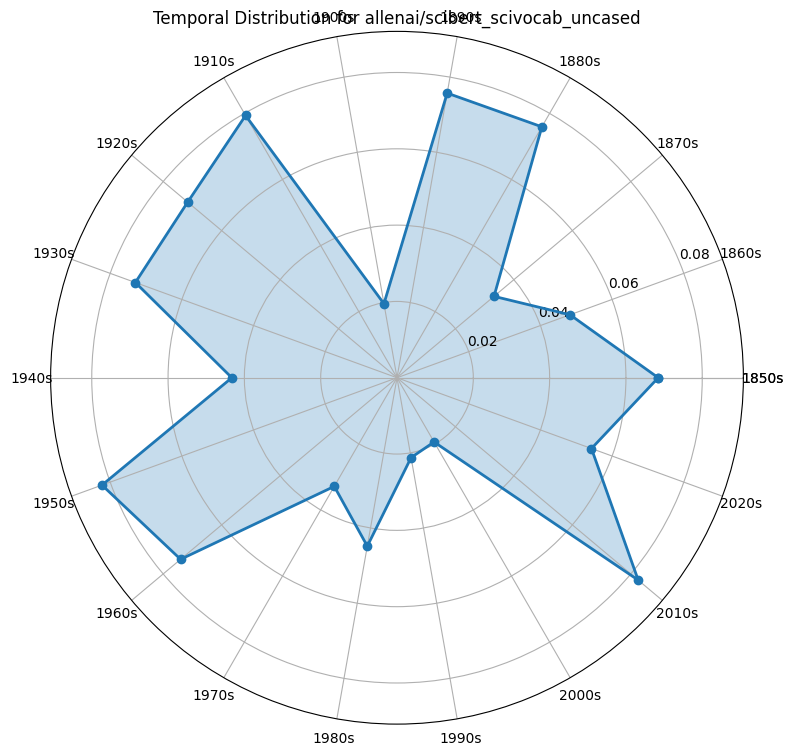

In [25]:
# Visualize models for key decades to identify relative strengths
def compare_models_by_decade(results):
    """Compare models by their representation of specific time periods."""
    models = list(results.keys())
    
    # Select representative decades from different eras
    key_decades = ['1890s', '1950s', '1990s', '2010s']
    available_decades = set()
    for model_results in results.values():
        available_decades.update(model_results["analysis"]["temporal_distribution"].keys())
    
    # Filter to only include decades that exist in the results
    key_decades = [d for d in key_decades if d in available_decades]
    
    # Create comparison visualization
    plt.figure(figsize=(14, 8))
    
    # Define bar positions
    x = np.arange(len(models))
    width = 0.2
    offsets = np.linspace(-(len(key_decades)-1)/2*width, (len(key_decades)-1)/2*width, len(key_decades))
    
    # Plot each decade as grouped bars
    for i, decade in enumerate(key_decades):
        values = [results[model]["analysis"]["temporal_distribution"].get(decade, 0) for model in models]
        plt.bar(x + offsets[i], values, width, label=decade)
    
    # Add labels and legend
    plt.xlabel('Model')
    plt.ylabel('Proportion')
    plt.title('Model Comparison by Selected Time Periods')
    plt.xticks(x, models, rotation=45, ha='right')
    plt.legend(title='Decade')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "model_decade_comparison.png")
    plt.close()
    
    # Create radar charts for each model showing temporal distribution
    # across all decades
    all_decades = sorted(list(available_decades))
    
    # First, get all data properly aligned
    model_data = {}
    for model in models:
        distribution = results[model]["analysis"]["temporal_distribution"]
        model_data[model] = [distribution.get(decade, 0) for decade in all_decades]
    
    # Function to create radar chart
    def create_radar_chart(model_name, values, decade_labels):
        # Compute angles for radar chart
        angles = np.linspace(0, 2*np.pi, len(decade_labels), endpoint=False).tolist()
        # Close the polygon
        values = values + [values[0]]
        angles = angles + [angles[0]]
        decade_labels = decade_labels + [decade_labels[0]]
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.plot(angles, values, 'o-', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
        ax.set_thetagrids(np.degrees(angles), decade_labels)
        ax.set_ylim(0, max(values)*1.1)
        ax.grid(True)
        plt.title(f'Temporal Distribution for {model_name}')
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f"{model_name}_radar_chart.png")
        plt.close()
    
    # Create radar charts for each model
    for model, values in model_data.items():
        create_radar_chart(model, values, all_decades)
    
    return {
        "key_decades": key_decades,
        "model_data": model_data
    }

# Run decade comparison
decade_comparison = compare_models_by_decade(results)

# Print key decade findings
print("\nKey Decade Representation:")
print("=" * 80)

key_decades = decade_comparison["key_decades"]
model_data = decade_comparison["model_data"]
models = list(model_data.keys())

# Create a table for the key decades
print(f"{'Model':<15}", end="")
for decade in key_decades:
    print(f"{decade:<10}", end="")
print()
print("-" * (15 + 10*len(key_decades)))

for model in models:
    distribution = results[model]["analysis"]["temporal_distribution"]
    print(f"{model:<15}", end="")
    for decade in key_decades:
        value = distribution.get(decade, 0)
        print(f"{value:.1%}{'':>5}", end="")
    print()

In [26]:
# Generate a comprehensive report summarizing findings
def generate_findings_report(results, trend_analysis):
    """Generate a Markdown report with key findings."""
    
    models = list(results.keys())
    
    # Get all decades from all models
    all_decades = set()
    for model_results in results.values():
        all_decades.update(model_results["analysis"]["temporal_distribution"].keys())
    decades = sorted(list(all_decades))
    
    # Start building the report
    report = "# Temporal Distribution Analysis of Language Model Training Data\n\n"
    report += f"Analysis date: {pd.Timestamp.now().strftime('%Y-%m-%d')}\n\n"
    
    report += "## Models Analyzed\n\n"
    for model in models:
        report += f"- {model}\n"
    
    report += "\n## Key Findings\n\n"
    
    # Recency bias analysis
    recency_models = sorted(trend_analysis["decade_centers"].items(), key=lambda x: x[1], reverse=True)
    report += "### Temporal Center Analysis\n\n"
    report += "Models sorted by how recent their training data appears to be:\n\n"
    report += "| Model | Temporal Center (year) |\n"
    report += "|-------|------------------------|\n"
    for model, center in recency_models:
        report += f"| {model} | {center:.1f} |\n"
    
    # Add reliability metrics
    report += "\n### Analysis Reliability\n\n"
    report += "| Model | Reliability Score | Coefficient of Variation | CI Width |\n"
    report += "|-------|-------------------|--------------------------|----------|\n"
    
    for model in models:
        metrics = results[model]["reliability_metrics"]
        report += f"| {model} | {metrics['reliability_score']:.1f}/100 | "
        report += f"{metrics['avg_coefficient_of_variation']:.2f} | "
        report += f"{metrics['avg_ci_width_normalized']:.2f} |\n"
    
    # Add temporal distribution table
    report += "\n## Detailed Temporal Distributions\n\n"
    report += "| Decade |"
    for model in models:
        report += f" {model} |"
    report += "\n|--------|"
    for _ in models:
        report += "---------|"
    report += "\n"
    
    for decade in decades:
        report += f"| {decade} |"
        for model in models:
            proportion = results[model]["analysis"]["temporal_distribution"].get(decade, 0)
            report += f" {proportion:.1%} |"
        report += "\n"
    
    # Add distinctive patterns
    report += "\n## Distinctive Temporal Markers\n\n"
    for model in models:
        report += f"### {model}\n\n"
        model_dist = results[model]["analysis"]["temporal_distribution"]
        top_decades = sorted(model_dist.items(), key=lambda x: x[1], reverse=True)[:3]
        
        for decade, proportion in top_decades:
            report += f"**{decade} ({proportion:.1%}):**\n\n"
            
            if decade in results[model]["analysis"]["distinctive_rules"]:
                distinctive = results[model]["analysis"]["distinctive_rules"][decade][:5]
                for rule, score in distinctive:
                    report += f"- '{rule}': {score:.2f}x more common than average\n"
            else:
                report += "No distinctive patterns found\n"
            
            report += "\n"
    
    # Add conclusion
    report += "\n## Conclusion\n\n"
    report += "This analysis provides insights into the temporal distribution of training data "
    report += "for various language models by examining their tokenizer patterns. The findings "
    report += "suggest significant variations in how different models represent content from "
    report += "different time periods, which may affect their performance on tasks requiring "
    report += "knowledge of specific eras.\n\n"
    
    report += "**Limitations:** The analysis is based on synthetic data and limited samples. "
    report += "Results should be interpreted as relative trends rather than exact proportions. "
    report += "Additional data and validation would strengthen these conclusions.\n"
    
    # Save the report
    report_file = RESULTS_DIR / "temporal_analysis_report.md"
    with open(report_file, 'w') as f:
        f.write(report)
    
    return report_file

# Generate and save the report
report_file = generate_findings_report(results, trend_analysis)
print(f"\nComprehensive report saved to: {report_file}")


Comprehensive report saved to: results/comparative_analysis/temporal_analysis_report.md
